# Using Price Volitility
According to the efficient frontier (https://en.wikipedia.org/wiki/Efficient_frontier), it is optimal from a risk return standpoint to have a mixed portfolio as it gives you a better outcome even if one of the components has strictly higher returns and strictly less risk. 

In part one, I will be combining this aspect of portfolio theory, data from the USDA, and options prices from the CBOE to determine the optimal crop mix for a theoretical farm in DeKalb County Illinois. Through this part I look to guide through the theoretical foundations of the exercise.

In part two, I will use the same techniques as described above but apply it to the 100 most agriculturally active and mixed counties in the United States. Here I hope to prove how this solution scales and see if the solutions that I propose is viable and reflects the ground truth of determining proper crop mixing.

In part three, I will apply this methodology to other countries using FAO data to determine how they can use this theory to improve resiliency across the world in a sustainable and quantitative manor.  

Disclaimer: This analysis only begins to scratch the surface of the complexities involved in agriculture. I am cognizant of the multitude of omitted variables such as fixed and variables costs independent of land involved in such an analysis but as it exists today, I hope that this analysis can provide a framework for diversifying seed portfolio and encouraging more sustainable agriculture practices.

In [1]:
import pandas as pd #Used for DataFrames and DataWrangling
import matplotlib.pyplot as plt #for plotting
import numpy as np #For general math
from utils import * #imports functions from utils file

# Part 1: DeKalb county

In [96]:
#This is Yield Data from the USDA in terms of bushels per Acre between 2000 and 2019
DeKalb_yields = pd.read_csv('Data/DeKalb yields.csv').set_index('Year')
DeKalb_yield_corr = DeKalb_yields.corr()
#Historical Prices for the last five years for Teucrium's Corn, Soyb, and Weat index
prices = pd.read_csv('Data/prices.csv').set_index('Date')
price_corr = prices.corr()
#Note: I used historical data instead of futures to measure correlation since there is no financial security my knowledge, that measures correlation.
#Finding the overall corrlation by multipling each component probably doesn't scales well(if I had to guess they would be negetivly corrolated due to supply and demand)
corr = DeKalb_yield_corr*price_corr
print(corr)

          corn      soyb      weat
corn  1.000000  0.506619  0.192544
soyb  0.506619  1.000000  0.099486
weat  0.192544  0.099486  1.000000


In [97]:
futures = pd.read_csv('Data/FuturesPrices.csv')
temp = futures[futures['Year']==2020].set_index('Commodity')['Price']
r = temp*DeKalb_yields.iloc[-1]/(7300*100)#According to USDA/NASS the price of land per acre=$7300 in DeKalb County
print(r)

Commodity
corn    0.088348
soyb    0.066461
weat    0.039791
dtype: float64


In [98]:
#Going to use Options Chains and implied Volitility to predict price risks
vol = (prices.var()*np.sqrt(12)+DeKalb_yields.var())/(7300)

In [99]:
%%time
portfolio = Portfolio(r,vol,corr)

Wall time: 2.46 s


        return       vol
weat  0.039791  0.040759
soyb  0.066461  0.019313
corn  0.088348  0.123979
Here we have a Monte Carlo Analysis with 1033 potential portfolio combinations.


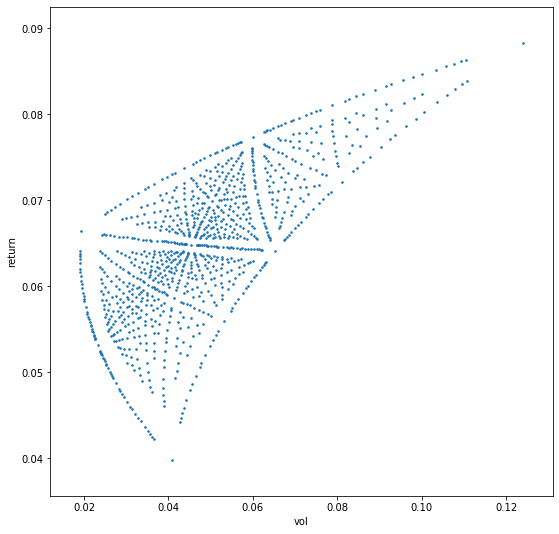

In [101]:
portfolio.df.plot.scatter('vol','return',s=2.5,figsize=(9,9))
print(portfolio.components())
print('Here we have a Monte Carlo Analysis with {} potential portfolio combinations.'.format(portfolio.df.shape[0]))

The graphic above demonstrates the fact that, at least in DeKalb County, some mix of corn and soybean create the optimal mix between risk and return. Moving futher, I use the Sharpe ratio (https://en.wikipedia.org/wiki/Sharpe_ratio) as a way to find which comonationa of products create the optimal portfolio in terms of risk returns. 

In [7]:
portfolio.sharpe(0.01)
portfolio.df.loc[portfolio.df['sharpe'].argmax()]
print(portfolio.stats())

        maxreturn    minvol  maxsharpe
corn     1.000000  0.000000   0.000000
soyb     0.000000  0.889000   1.000000
weat     0.000000  0.111000   0.000000
return   0.088348  0.063501   0.066461
vol      0.123979  0.019005   0.019313
sharpe   0.631944  2.815054   2.923449


Now, using Google Earth Engine and USDA Data, we scrape the true composite mix of crops being planted in DeKalb County and measure the price volitility optimum of farmers. See EarthEngine.py file for more detail.

In [8]:
land = pd.read_csv('Data/land.csv').set_index('index')
land.index = list(map(lambda x:str(x).rjust(5,'0'),land.index))

land.loc['17037']

soyb    0.339435
corn    0.653880
weat    0.006685
Name: 17037, dtype: float64

Here we see that the true mix of corn to soybeans is 66/33 rather than 100% Soybean. There are many reasons for this potentail breakdown but one worth looking into which deviates from the traditional methodology is setting the risk free intrest rate hire. Since we are in a low intrest environment and taking out loans for farming is not in fact risk free, it is likly that farmers aren't able to borrow at even close to this rate. 

Now I will take a range of intrest rates to find which rate would make a  66/33 split

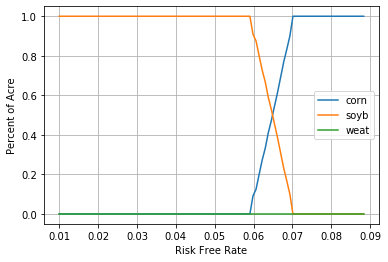

In [9]:
rates = np.linspace(0.01,portfolio.df['return'].max(),100)
out={}
for i in rates:
    portfolio.sharpe(i)
    out[i]=portfolio.df.loc[portfolio.df['sharpe'].argmax()]
pd.DataFrame(out).T[['corn','soyb','weat']].plot(grid=True)
plt.xlabel('Risk Free Rate')
plt.ylabel("Percent of Acre")
plt.show()

Here we show that if the intrest rate was 6.7% then the compostion between corn and Soybeans makes sense for farmers on this field. 

# Part 2: Expaning the Geogrophy

In part two, I will apply the same methodologies as shown above for the 1000 highest producing counties in the United States

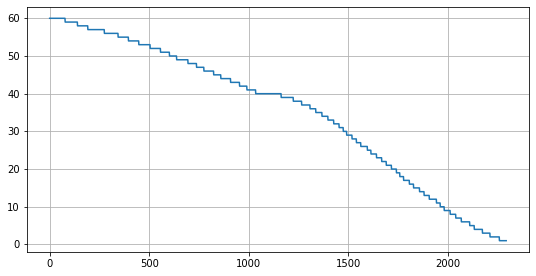

,soyb,corn,weat
17055,0.744623,0.255377,0.000000
26161,0.581863,0.338893,0.079244
47147,0.353899,0.646101,0.000000
26151,0.517632,0.347422,0.134946
21211,0.607079,0.392921,0.000000
...,...,...,...
29079,0.690667,0.309333,0.000000
20023,0.013790,0.394865,0.591344
31103,0.211287,0.772615,0.016097
29075,0.701903,0.289042,0.009055


In [10]:
yields = pd.read_csv('Data/yields.csv')
yields['ANSI'] = list(map(lambda x:str(x).rjust(5,'0'),yields['ANSI']))

temp = yields.groupby('ANSI').count()[['corn','soyb','weat']].sum(1).sort_values(ascending=False)
temp.reset_index(drop=True).plot(grid=True,figsize=(9,4.5))
plt.show()
#print(list(map(str,temp.head(1000).index)))

land

In [11]:
temp = yields.set_index(['ANSI','Year']).unstack()
corrs={}
vols = {}
yields_out={}
for i in temp.index:
    yields_out[i]=temp.loc[i].unstack().T.tail(5).mean()
    corrs[i]=temp.loc[i].unstack().T.corr().fillna(1)
    vols[i]=temp.loc[i].unstack().T.var()
yields_out = pd.DataFrame(yields_out).T.fillna(0)
vols = pd.DataFrame(vols).T.fillna(np.inf)
vols = ((prices.var()*np.sqrt(12)+vols)/(7300)).fillna(np.inf)

In [61]:
temp = futures[futures['Year']==2020].set_index('Commodity')['Price']
temp
rs = temp*yields_out#/(7300*100)
rs = rs.reset_index()
rs.index = rs['index'].apply(lambda x:x[:2])

landPrice = pd.read_csv('Data/landPrice.csv')
landPrice['State ANSI'] =landPrice['State ANSI'].apply(lambda x: str(x).rjust(2,'0'))
landPrice = landPrice.set_index('State ANSI')['Value'].apply(lambda x:int(x.replace(',','')))

rs = rs.join(landPrice*100)

rs['corn']= rs['corn'] /rs['Value']
rs['soyb']= rs['soyb'] /rs['Value']
rs['weat']= rs['weat'] /rs['Value']

rs = rs.set_index('index')[['corn','soyb','weat']]

In [62]:
print(rs.head(5))
print(vols.head(5))
print(corrs[list(corrs.keys())[516]])

           corn      soyb  weat
index                          
01001  0.166650  0.000000   0.0
01003  0.152376  0.109775   0.0
01005  0.185963  0.132544   0.0
01009  0.127876  0.111428   0.0
01011  0.134449  0.000000   0.0
           corn      soyb      weat
01001  0.313450  0.017130  0.022924
01003  0.143450  0.007917  0.007767
01005  0.244120       inf  0.060835
01009  0.123730  0.015458       inf
01011  0.124145       inf       inf
          corn      soyb  weat
corn  1.000000  0.682948   1.0
soyb  0.682948  1.000000   1.0
weat  1.000000  1.000000   1.0


In [63]:
out = {}
for i,j in enumerate(land.index):
    portfolio = Portfolio(rs.loc[j],vols.loc[j],corrs[j])
    portfolio.sharpe(0.066)
    out[j] = portfolio.stats()
    if(i%25==0):
        print(np.round(i/land.shape[0],3))
print('Done!')

0.0
0.02
0.04
0.07
0.09
0.11
0.13
0.15
0.18
0.2
0.22
0.24
0.26
0.29
0.31
0.33
0.35
0.37
0.4
0.42
0.44
0.46
0.48
0.51
0.53
0.55
0.57
0.59
0.62
0.64
0.66
0.68
0.7
0.73
0.75
0.77
0.79
0.81
0.84
0.86
0.88
0.9
0.92
0.95
0.97
0.99


C:\Users\Berma\Documents\PriceVol\utils.py:45: RuntimeWarning: invalid value encountered in double_scalars
  out+=corr[i][j]*p[i]*p[j]*np.sqrt(vol[i])*np.sqrt(vol[j])
C:\Users\Berma\Documents\PriceVol\utils.py:43: RuntimeWarning: invalid value encountered in double_scalars
  out+= p[i]*vol[i]


In [66]:
out1 = pd.DataFrame(out[list(out.keys())[0]]['maxsharpe'])
out1.columns = [list(out.keys())[0]]
for i in list(out.keys())[1:]:
    hold = pd.DataFrame(out[i]['maxsharpe'])
    hold.columns = [i]
    out1 = out1.join(hold)
out1=out1.T
out1

,corn,soyb,weat,return,vol,sharpe
17055,1.000,0.000,0.000,0.066738,0.359043,0.002056
26161,0.000,0.727,0.273,0.084349,0.014701,1.248166
47147,0.000,0.727,0.273,0.098677,0.024910,1.311811
26151,0.000,0.714,0.286,0.096999,0.019560,1.584829
21211,0.000,0.857,0.143,0.097726,0.027868,1.138443
...,...,...,...,...,...,...
29079,0.000,1.000,0.000,0.096011,0.015395,1.949385
20023,0.000,1.000,0.000,0.230673,0.021354,7.711608
31103,0.000,1.000,0.000,0.114491,0.021150,2.292763
29075,0.000,1.000,0.000,0.112763,0.022973,2.035532


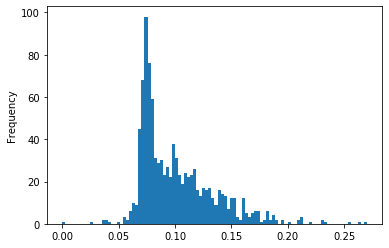

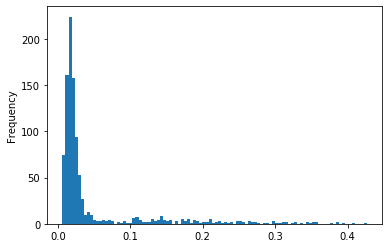

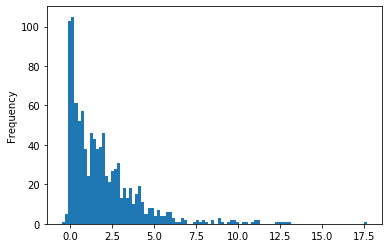

In [76]:
out1['return'].plot.hist(bins=100)
plt.show()
out1[out1['vol']!=np.inf]['vol'].plot.hist(bins=100)
plt.show()
out1['sharpe'].plot.hist(bins=100)
plt.show()

In [93]:
out2 = out1[['corn','soyb','weat']].join(land[['corn','soyb','weat']],lsuffix='_pred',rsuffix='_land')
out2.head(10)

,corn_pred,soyb_pred,weat_pred,corn_land,soyb_land,weat_land
17055,1.0,0.000,0.000,0.255377,0.744623,0.000000
26161,0.0,0.727,0.273,0.338893,0.581863,0.079244
47147,0.0,0.727,0.273,0.646101,0.353899,0.000000
26151,0.0,0.714,0.286,0.347422,0.517632,0.134946
21211,0.0,0.857,0.143,0.392921,0.607079,0.000000
26147,0.0,0.375,0.625,0.173093,0.772493,0.054414
26145,0.0,0.000,1.000,0.376969,0.567484,0.055547
31095,0.0,1.000,0.000,0.512816,0.476549,0.010634
39011,0.0,1.000,0.000,0.322013,0.662831,0.015156
21219,0.0,0.857,0.143,0.747486,0.252514,0.000000


In [90]:
from sklearn.metrics import r2_score

for i in ['corn','soyb','weat']:
    print(i,r2_score(out2[i+'_pred'],out2[i+'_land']))

corn -0.9906407952764082
soyb -0.7125391831398986
weat -0.1516705064660937


As seen above the predictive power of this model is non-existent. I suspect there was some error in the code or some omitted variable which plays an important role in making these kinds of decisions(or maybe there is just a tremendous amount of inefficiency). Regardless, I will continue this later…